In [1]:
%load_ext autoreload
%autoreload 2

In [63]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from data_handler import DataHandler
from modelling.fit_image import load_model
from modelling.utils.remove_illumination import remove_illumination

%matplotlib inline

In [78]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#dh = DataHandler('people/CFD/LF-249/', device)
#dh = DataHandler('people/CFD/WM-256/', device)
dh = DataHandler('people/enes3/', device)
model, optimizer = load_model(dh.full_individual, dh.folder, device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


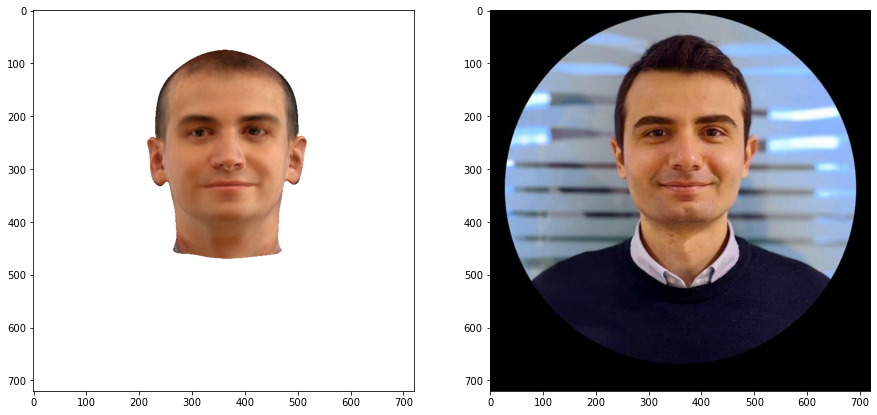

In [79]:
_, image_init = model()
_, axs = plt.subplots(1, 2, figsize=(15, 15))
axs = axs.flatten()
axs[0].imshow(image_init[0, ..., :3].detach().cpu().numpy())
axs[1].imshow(model.individual.source_image.detach().cpu())
plt.show()

In [80]:
mesh = model.face_model.compute_face()
# Get the output from rasterization
fragments = model.render_model.renderer.rasterizer(mesh)

# pix_to_face is of shape (N, H, W, 1)
pix_to_face = fragments.pix_to_face

# (F, 3) where F is the total number of faces across all the meshes in the batch
packed_faces = mesh.faces_packed()

# (V, 3) where V is the total number of verts across all the meshes in the batch
packed_verts = mesh.verts_packed()
vertex_visibility_map = torch.zeros(packed_verts.shape[0])   # (V,)

# Indices of unique visible faces
visible_faces = pix_to_face.unique()   # (num_visible_faces )

# Get Indices of unique visible verts using the vertex indices in the faces
visible_verts_idx = packed_faces[visible_faces]    # (num_visible_faces,  3)
unique_visible_verts_idx = torch.unique(visible_verts_idx)   # (num_visible_verts, )

# Update visibility indicator to 1 for all visible vertices 
vertex_visibility_map[unique_visible_verts_idx] = 1.0

In [81]:
R , T = model.render_model.compute_rigid_transformation()
verts = mesh.verts_padded()[:, unique_visible_verts_idx, :]
camera = model.render_model.renderer.rasterizer.cameras
proj_verts = camera.transform_points_screen(verts, 
                                           torch.tensor([[model.individual.image_shape[1],                                                               model.individual.image_shape[0]]]).to(model.device),
                                           R=R, 
                                           T=T)
pixel_indices = torch.round(proj_verts[...,:2]).long()

In [82]:
valid_face_vert_idx = torch.Tensor([v for i,v in enumerate(unique_visible_verts_idx) if model.individual.image_mask[pixel_indices[0,i,1], pixel_indices[0,i,0]] == 1]).long()

In [83]:
R , T = model.render_model.compute_rigid_transformation()
verts = mesh.verts_padded()[:, valid_face_vert_idx, :]
camera = model.render_model.renderer.rasterizer.cameras
proj_verts = camera.transform_points_screen(verts, 
                                           torch.tensor([[model.individual.image_shape[1],                                                               model.individual.image_shape[0]]]).to(model.device),
                                           R=R, 
                                           T=T)
pixel_indices = torch.round(proj_verts[...,:2]).long()

In [84]:
new_color = torch.ones((proj_verts.shape)).to(device)

In [85]:
corrected_image = remove_illumination(model)
for i in range(proj_verts.shape[1]):
    new_color[0, i, :] = corrected_image[pixel_indices[0,i,1], pixel_indices[0,i,0]]

In [86]:
mesh.textures._verts_features_padded[0, valid_face_vert_idx, :] = new_color

In [87]:
R , T = model.render_model.compute_rigid_transformation()
image = model.render_model.renderer(meshes_world=mesh, R=R, T=T)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


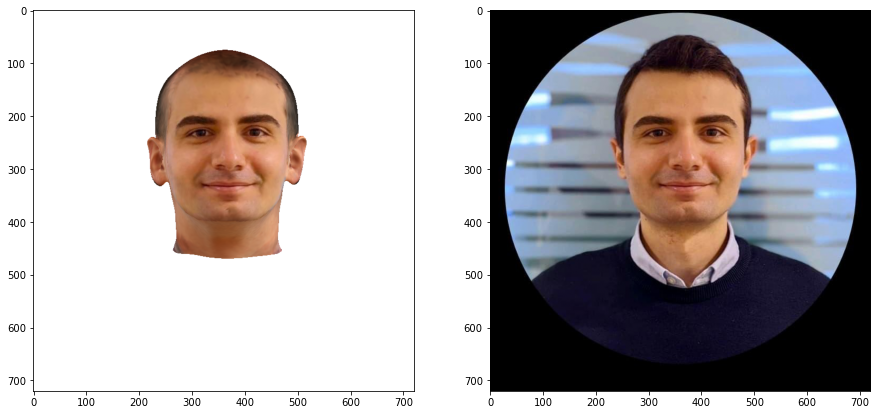

In [88]:
_, axs = plt.subplots(1, 2, figsize=(15, 15))
axs = axs.flatten()
axs[0].imshow(image[0, ..., :3].detach().cpu().numpy())
axs[1].imshow(model.individual.source_image.detach().cpu())
plt.show()

In [28]:
model.render_model.euler_angles

Parameter containing:
tensor([[-0.1181,  3.1087,  0.0131]], device='cuda:0', requires_grad=True)

In [33]:
model.render_model.euler_angles[0,1] = 3.10426